<a href="https://colab.research.google.com/github/Brycexxx/fastai/blob/master/lesson3_planet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:

from fastai.vision import *

In [0]:
! pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.2)


In [0]:
! mkdir -p ~/.kaggle/
! mv kaggle.json ~/.kaggle/

In [3]:
Config.data_path()

PosixPath('/root/.fastai/data')

In [4]:
path = Config.data_path() / 'planet'
path.mkdir(parents=True, exist_ok=True)
path


PosixPath('/root/.fastai/data/planet')

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

 99% 596M/600M [00:03<00:00, 129MB/s]
100% 600M/600M [00:03<00:00, 173MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 60.2MB/s]


In [0]:
! sudo apt install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

In [0]:
! ls -al /root/.fastai/data/planet

total 617448
drwxr-xr-x 4 root root      4096 Feb  9 03:42 .
drwxr-xr-x 3 root root      4096 Feb  9 03:40 ..
drwxrwxr-x 2 root root      4096 May  9  2017 __MACOSX
drwxrwxr-x 2 1003 1004   1355776 Apr 19  2017 train-jpg
-rw-r--r-- 1 root root 629296207 Feb  9 03:40 train-jpg.tar.7z
-rw-r--r-- 1 root root   1432177 May  9  2017 train_v2.csv
-rw-r--r-- 1 root root    162930 Feb  9 03:40 train_v2.csv.zip


In [0]:
df = pd.read_csv(path / 'train_v2.csv')

In [6]:
df.tail()

,image_name,tags
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road
40478,train_40478,agriculture cultivation partly_cloudy primary


In [0]:
tfms = get_transforms(flip_vert=True, max_zoom=1.05, max_lighting=0.1, max_warp=.0)

In [0]:
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
                    .random_split_by_pct(0.2)
                    .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
           .databunch().normalize(imagenet_stats))

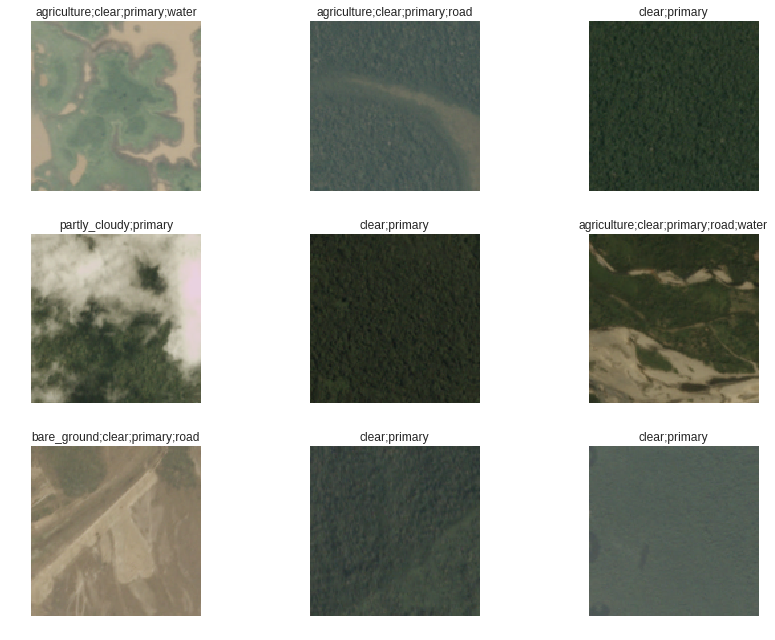

In [10]:
data.show_batch(rows=3, figsize=(12, 9))

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [0]:
learn = create_cnn(data, models.resnet50, metrics=[acc_02, f_score], ps=0.3)

In [18]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


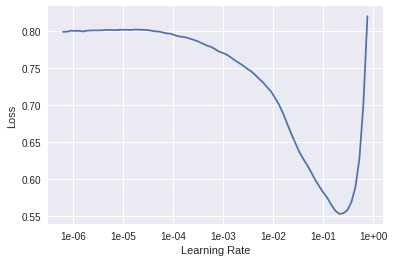

In [19]:
learn.recorder.plot()

In [0]:
lr = 2e-2

In [21]:
learn.fit_one_cycle(6, max_lr=slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.118063,0.108230,0.944541,0.902944
2,0.112221,0.099152,0.948821,0.915684
3,0.104548,0.096852,0.948785,0.916486
4,0.097277,0.090918,0.954889,0.922453
5,0.091481,0.089225,0.955819,0.924972
6,0.088289,0.084678,0.957592,0.926954


In [0]:
learn.save('stage-1-resnet50')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


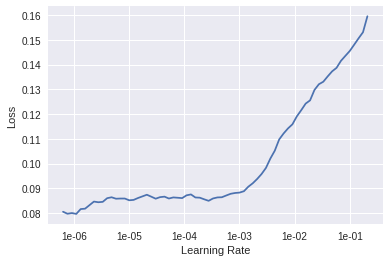

In [23]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(6, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.088008,0.093866,0.955695,0.926344
2,0.086593,0.088079,0.957897,0.926589
3,0.086556,0.086252,0.957773,0.926928
4,0.082913,0.087089,0.957294,0.927235
5,0.081016,0.083794,0.958166,0.928564
6,0.077677,0.084179,0.958427,0.928506


In [0]:
learn.save('stage-2-resnet50')

In [0]:
data = (src.transform(tfms, size=256)
           .databunch().normalize(imagenet_stats))

In [0]:
learn.data = data

In [0]:
learn.freeze()
learn.save('stage-2-tmp256-renet50')

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


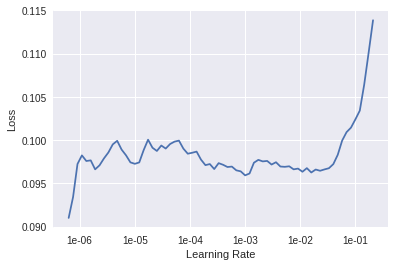

In [29]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8, max_lr=slice(5e-3))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
